In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
import numpy as np

In [6]:
train_parquet = pq.ParquetFile('train_series.parquet')

#IDs
target_series_ids = ['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d', '05e1944c3818']

for target_series_id in target_series_ids:
    data_frames = []

    # iterate through batches in the parquet file
    for batch in train_parquet.iter_batches():
        batch_df = batch.to_pandas()
        # filter
        filtered_data = batch_df[batch_df['series_id'] == target_series_id]
        data_frames.append(filtered_data)

    # combine
    combined_data = pd.concat(data_frames, ignore_index=True)
    combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'], utc=True)

    train_events = pd.read_csv('train_events.csv')
    train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], utc=True)

    # merge the combined data with event data
    filtered_events = train_events[train_events['series_id'] == target_series_id]
    merged_data = pd.merge(combined_data, filtered_events, on=['timestamp', 'series_id'], how='left')
    
def plot_data(merged_data):
    a, plot = plt.subplots(2, 1, figsize = (20,10))
    
    for i in range(len(merged_data)):
        
        if merged_data['event'].values[i] == 'onset':
            plot[1].axvline(merged_data.index[i], linestyle = "--", color = "green")
            plot[0].axvline(merged_data.index[i], linestyle = "--", color = "green")
            
        if merged_data['event'].values[i] == 'wakeup':
            plot[1].axvline(merged_data.index[i], linestyle = "--", color = "pink")
            plot[0].axvline(merged_data.index[i], linestyle = "--", color = "pink")
            
    plot[0].plot(merged_data.index, merged_data['enmo'])
    plot[0].set_ylabel('enmo')
    plot[0].set_xlabel('step')
    plot[1].plot(merged_data.index, merged_data['anglez'])
    plot[1].set_ylabel('anglez')
    plot[1].set_xlabel('step')
    
    plt.show()

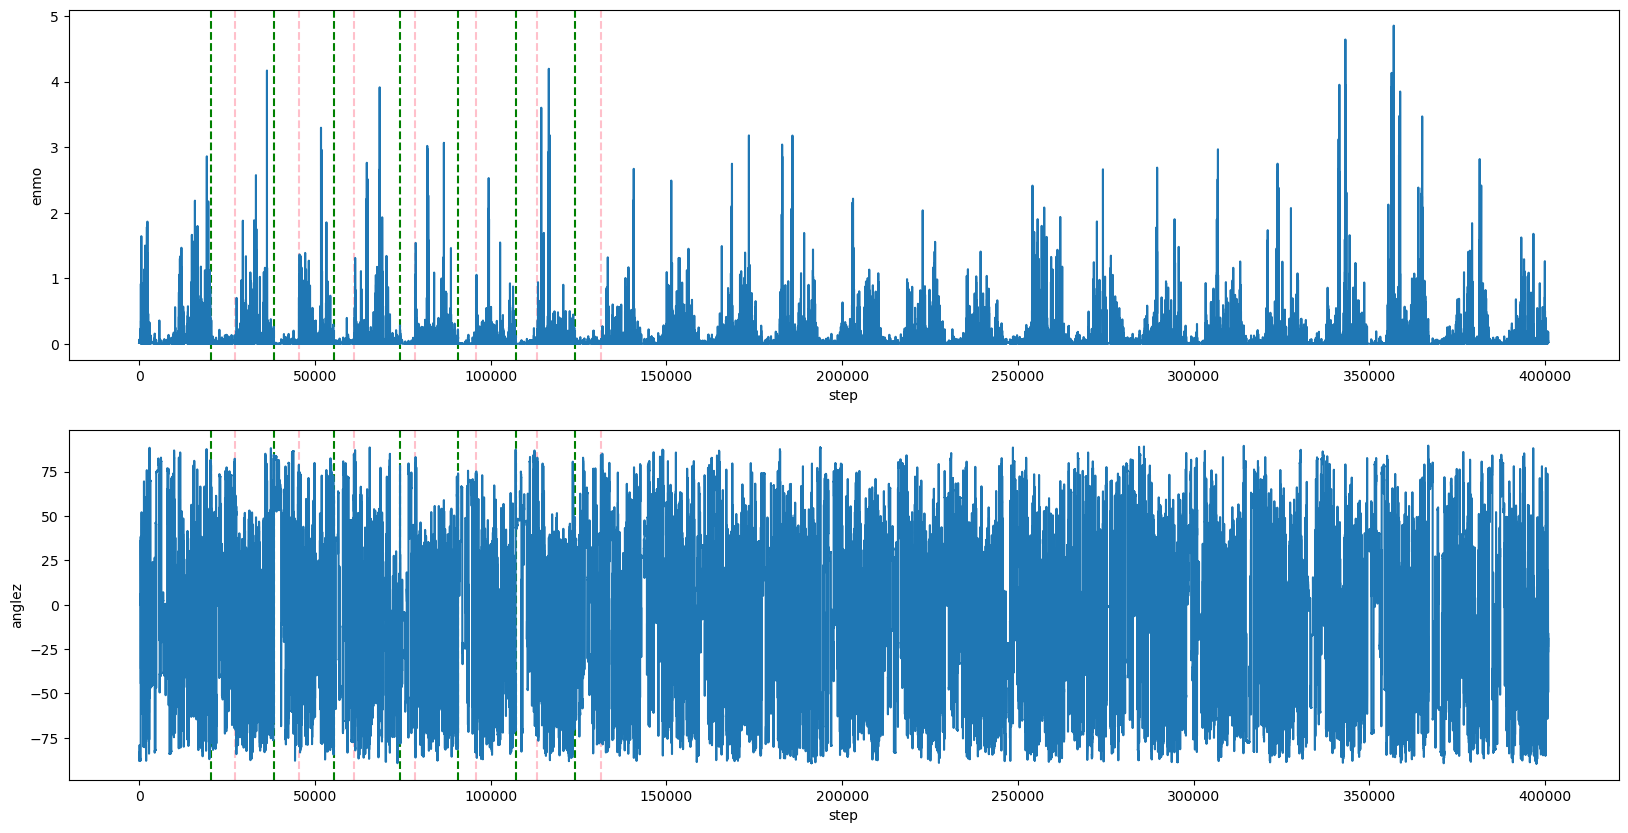

In [7]:
plot_data(merged_data)

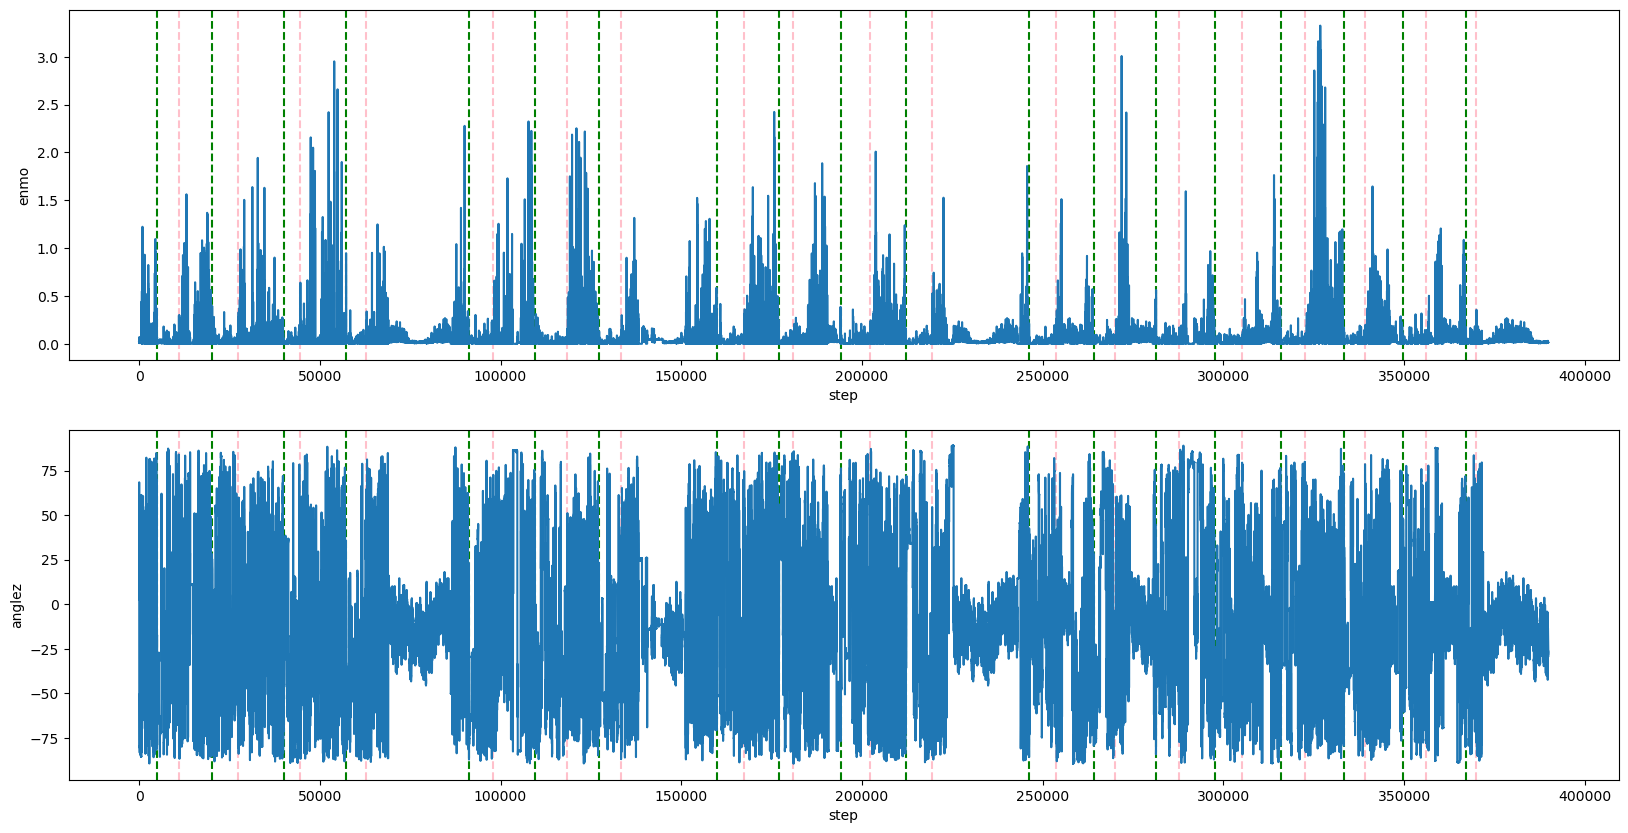

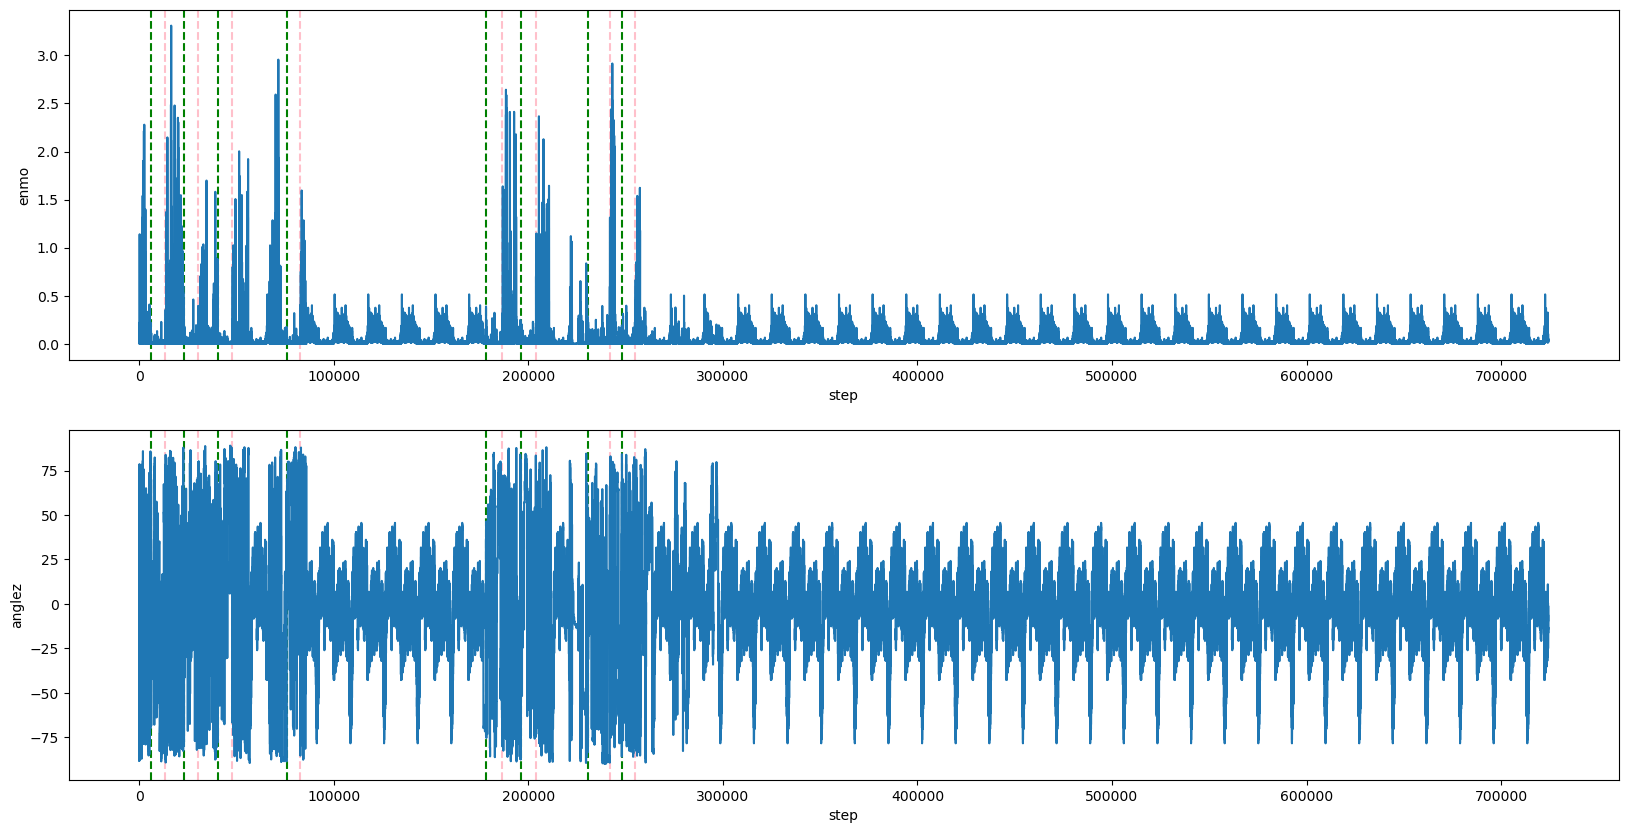

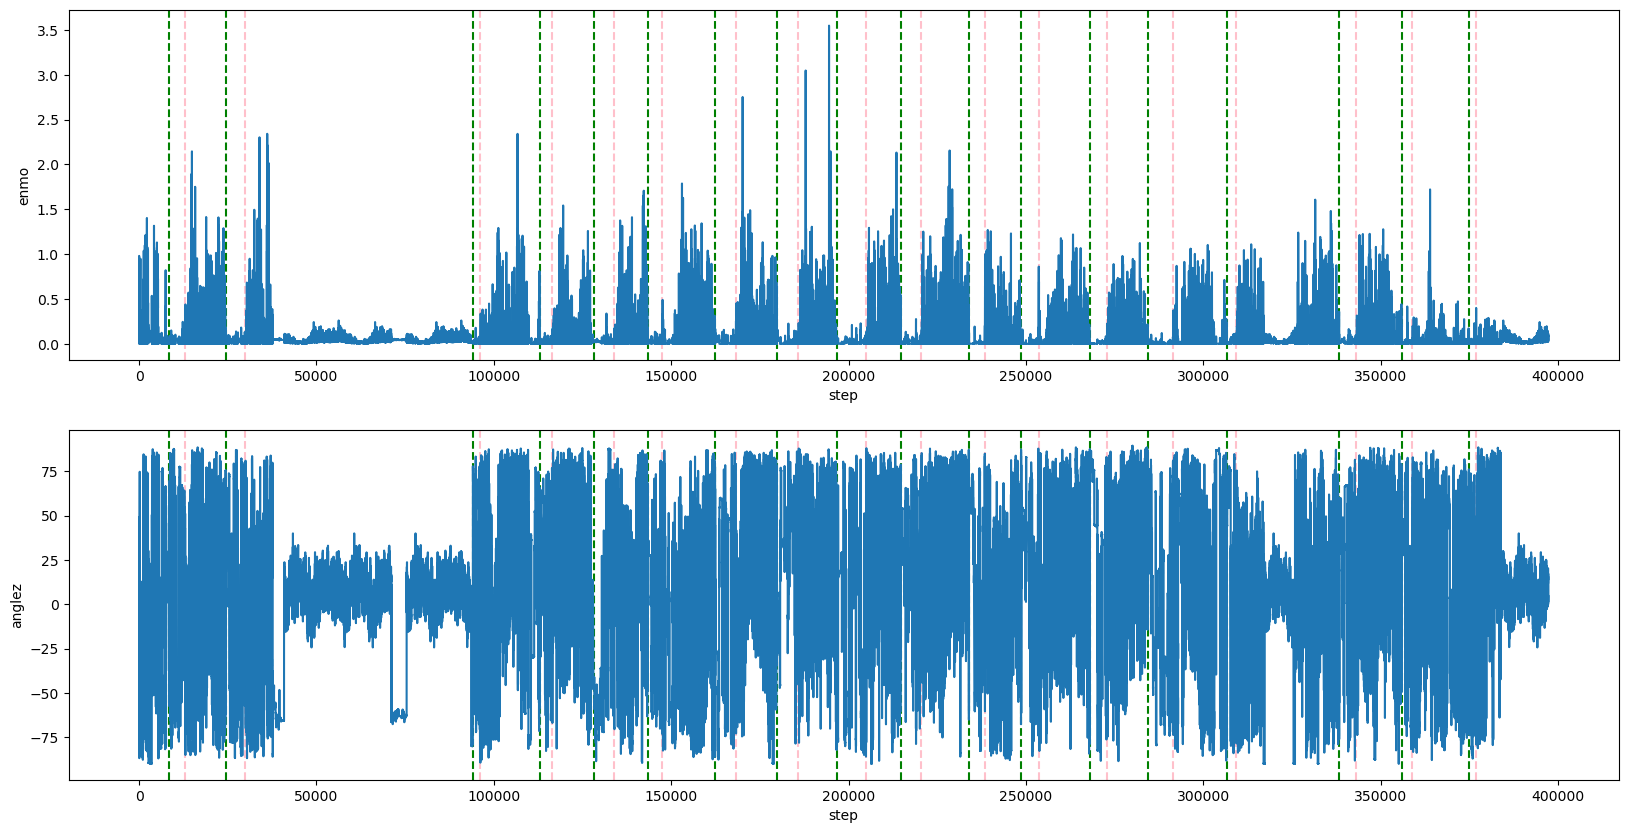

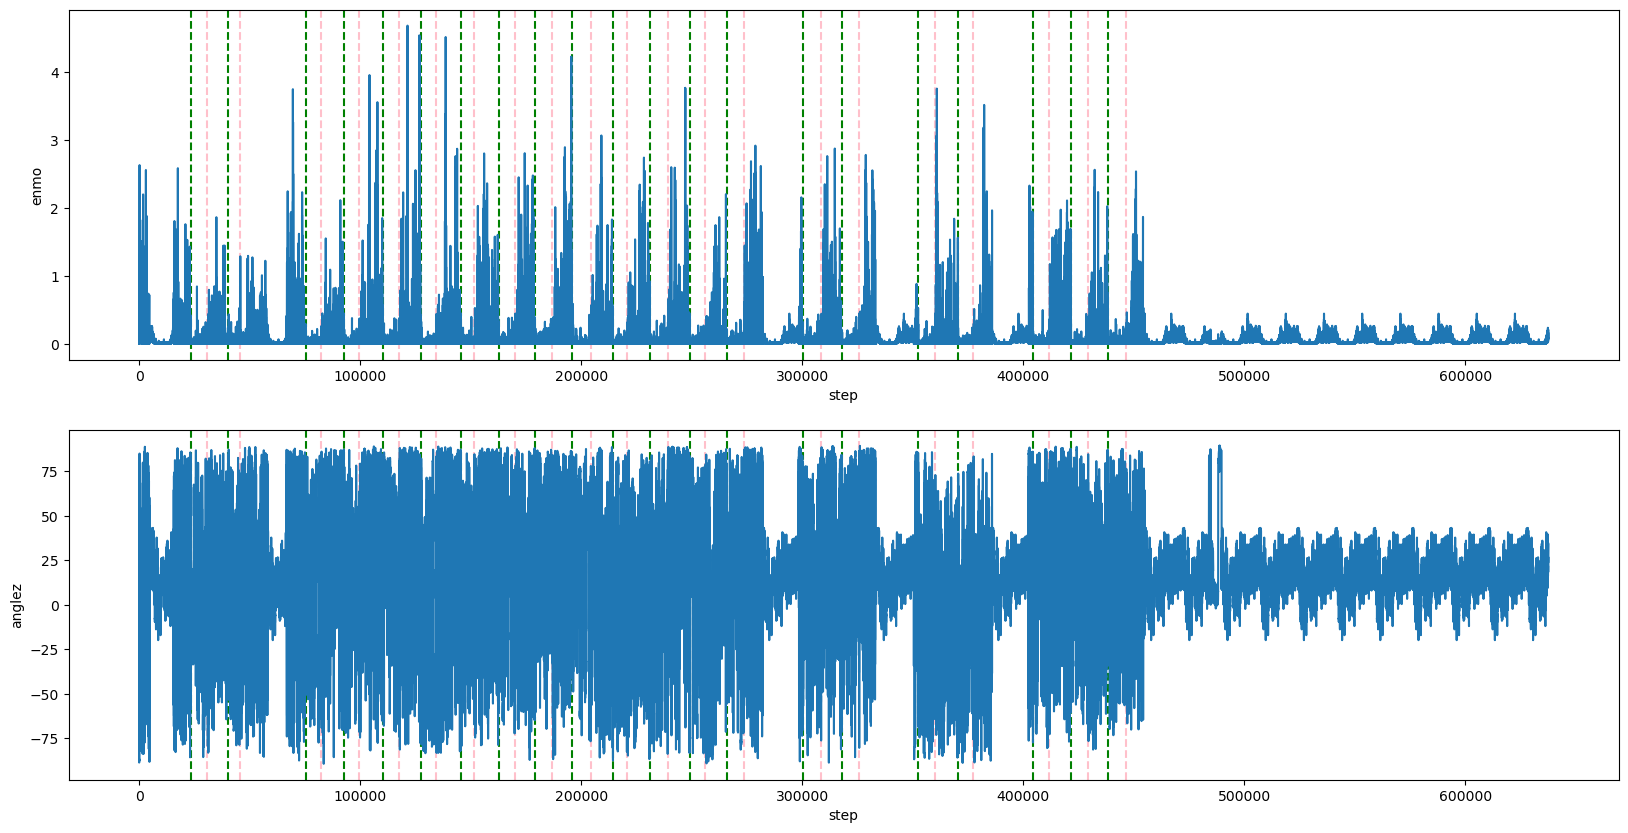

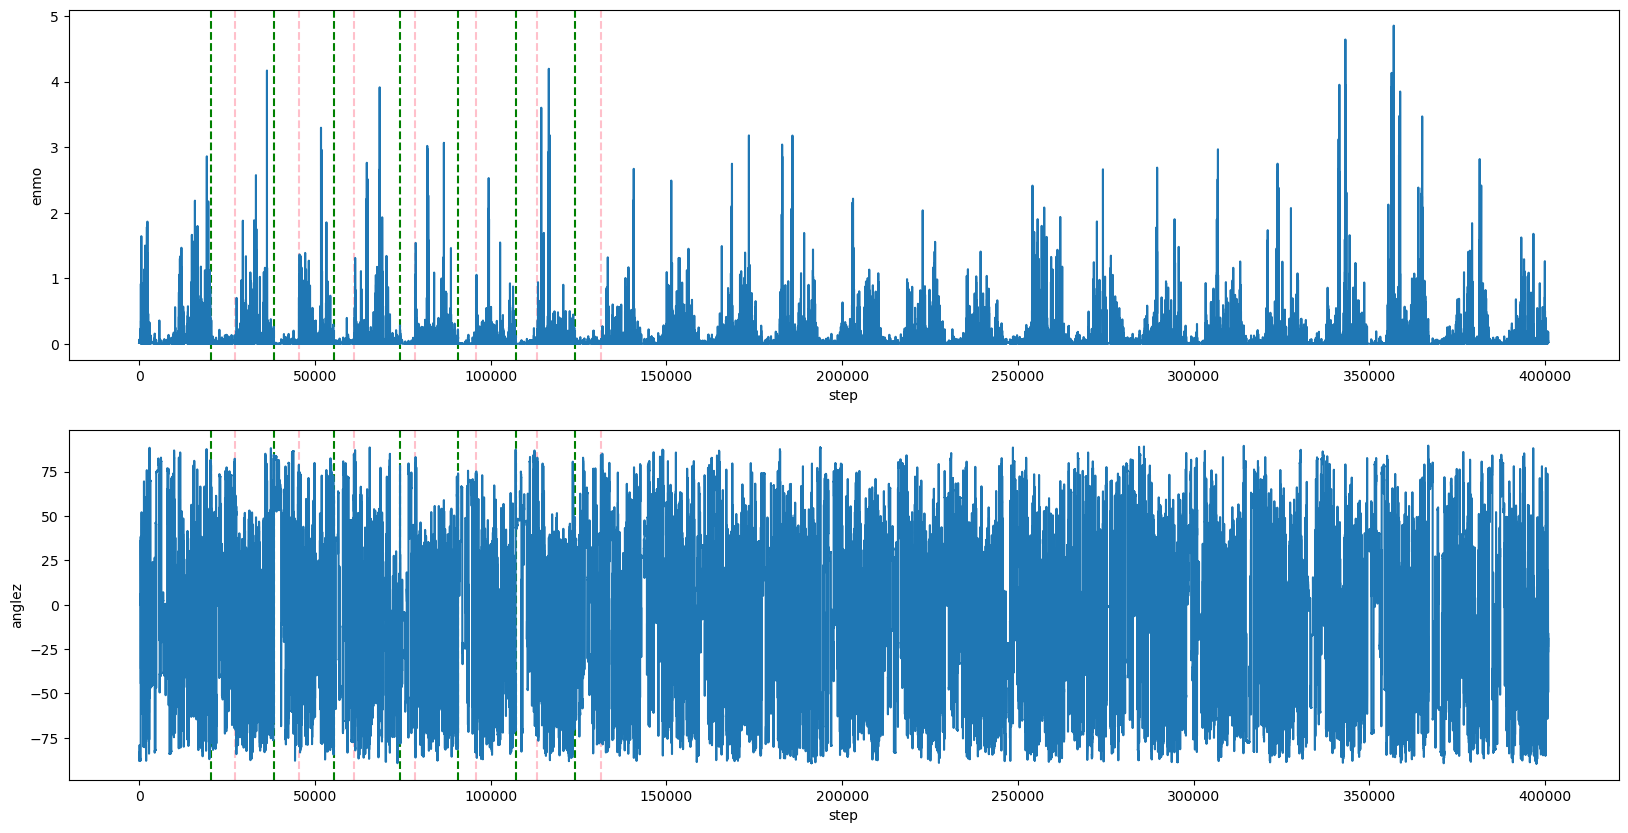

In [24]:
train_parquet = pq.ParquetFile('train_series.parquet')

target_series_ids = ['038441c925bb', '03d92c9f6f8a', '0402a003dae9', '04f547b8017d', '05e1944c3818']

for target_series_id in target_series_ids:
    data_frames = []

    # iterate through batches in the parquet file
    for batch in train_parquet.iter_batches():
        batch_df = batch.to_pandas()
        filtered_data = batch_df[batch_df['series_id'] == target_series_id]
        data_frames.append(filtered_data)

    # combine
    combined_data = pd.concat(data_frames, ignore_index=True)
    combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'], utc=True)

    train_events = pd.read_csv('train_events.csv')
    train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], utc=True)

    # merge combined data and event data
    filtered_events = train_events[train_events['series_id'] == target_series_id]
    merged_data = pd.merge(combined_data, filtered_events, on=['timestamp', 'series_id'], how='left')

    plot_data(merged_data)

In [20]:
merged_data

,series_id,step_x,timestamp,anglez,enmo,night,event,step_y
0,038441c925bb,0,2018-08-14 19:30:00+00:00,2.636700,0.0217,NaN,NaN,NaN
1,038441c925bb,1,2018-08-14 19:30:05+00:00,2.636800,0.0215,NaN,NaN,NaN
2,038441c925bb,2,2018-08-14 19:30:10+00:00,2.637000,0.0216,NaN,NaN,NaN
3,038441c925bb,3,2018-08-14 19:30:15+00:00,2.636800,0.0213,NaN,NaN,NaN
4,038441c925bb,4,2018-08-14 19:30:20+00:00,2.636800,0.0215,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
389875,038441c925bb,389875,2018-09-06 08:59:35+00:00,-27.373899,0.0110,NaN,NaN,NaN
389876,038441c925bb,389876,2018-09-06 08:59:40+00:00,-27.493799,0.0110,NaN,NaN,NaN
389877,038441c925bb,389877,2018-09-06 08:59:45+00:00,-27.533701,0.0111,NaN,NaN,NaN
389878,038441c925bb,389878,2018-09-06 08:59:50+00:00,-28.003599,0.0111,NaN,NaN,NaN


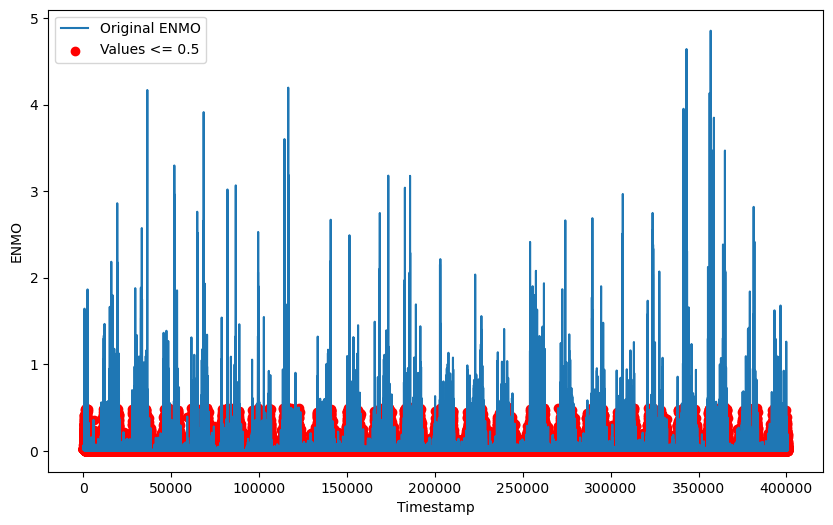

In [11]:
merged_data = pd.merge(combined_data, filtered_events, on=['timestamp', 'series_id'], how='left')

enmo_data = merged_data['enmo'].values

motif_threshold = 0.5

motif_indices = np.where(enmo_data <= motif_threshold)[0]

plt.figure(figsize=(10, 6))
plt.plot(enmo_data, label='Original ENMO')
plt.scatter(motif_indices, enmo_data[motif_indices], c='r', label='Values <= 0.5')
plt.xlabel('Timestamp')
plt.ylabel('ENMO')
plt.legend()
plt.show()

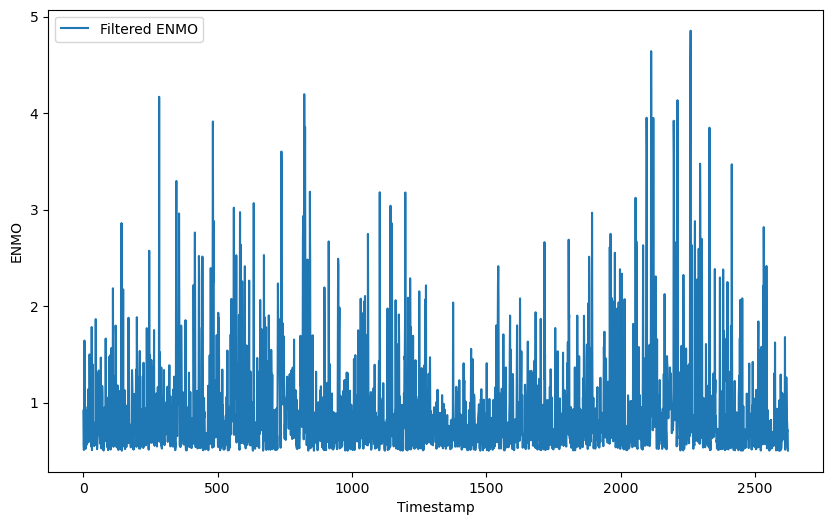

In [25]:
enmo_data = merged_data['enmo'].values

motif_threshold = 0.5

filtered_data = enmo_data[enmo_data > motif_threshold]

plt.figure(figsize=(10, 6))
#plt.plot(enmo_data, label='Original ENMO')
#plt.scatter(np.where(enmo_data <= motif_threshold)[0], enmo_data[enmo_data <= motif_threshold], c='r', label='Values <= 0.5')
#plt.plot(filtered_data, label='Filtered ENMO', linestyle='--')
plt.plot(filtered_data, label='Filtered ENMO')
plt.xlabel('Timestamp')
plt.ylabel('ENMO')
plt.legend()
plt.show()


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder

features = ['anglez', 'enmo']

# Labeling
merged_data['label'] = 'none'
merged_data.loc[merged_data['event'] == 'onset', 'label'] = 'onset'
merged_data.loc[merged_data['event'] == 'wakeup', 'label'] = 'offset'

# Convert labels to numerical values
label_encoder = LabelEncoder()
merged_data['label'] = label_encoder.fit_transform(merged_data['label'])

# Create sequences and labels
sequence_length = 10  # Define the length of each sequence
sequences = []
labels = []

for i in range(len(merged_data) - sequence_length + 1):
    seq = merged_data.iloc[i:i+sequence_length][features].values
    label = merged_data.iloc[i+sequence_length-1]['label']
    sequences.append(seq)
    labels.append(label)

# Convert numpy arrays to tensors
sequences = torch.tensor(sequences, dtype=torch.float32)
labels = torch.tensor(labels, dtype=torch.long)

# Train-test split
split_idx = int(len(sequences) * 0.8)
train_sequences, test_sequences = sequences[:split_idx], sequences[split_idx:]
train_labels, test_labels = labels[:split_idx], labels[split_idx:]

# Long Short Term Memory
class SleepLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SleepLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Take the output from the last time step
        return out

# Initialize model, loss function, and optimizer
input_size = len(features)
hidden_size = 64
num_classes = len(label_encoder.classes_)
model = SleepLSTM(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
batch_size = 32

for epoch in range(num_epochs):
    for i in range(0, len(train_sequences), batch_size):
        inputs = train_sequences[i:i+batch_size]
        targets = train_labels[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        test_outputs = model(test_sequences)
        test_loss = criterion(test_outputs, test_labels)
        predictions = torch.argmax(test_outputs, dim=1)
        accuracy = torch.sum(predictions == test_labels).item() / len(test_labels)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Loss: {test_loss.item():.4f}, Accuracy: {accuracy:.4f}')

# Evaluate the trained model on your test data and make predictions
model.eval()
with torch.no_grad():
    test_outputs = model(test_sequences)
    predictions = torch.argmax(test_outputs, dim=1)
    accuracy = torch.sum(predictions == test_labels).item() / len(test_labels)

print(f'Final Accuracy on Test Set: {accuracy:.4f}')

C:\Users\aemsh\AppData\Local\Temp\ipykernel_24352\2944667686.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  sequences = torch.tensor(sequences, dtype=torch.float32)


Epoch [1/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [2/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [3/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [4/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [5/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [6/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [7/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [8/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0000, Validation Loss: 0.0000, Accuracy: 1.0000
Final Accuracy on Test Set: 1.0000


C:\Users\aemsh\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:999: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


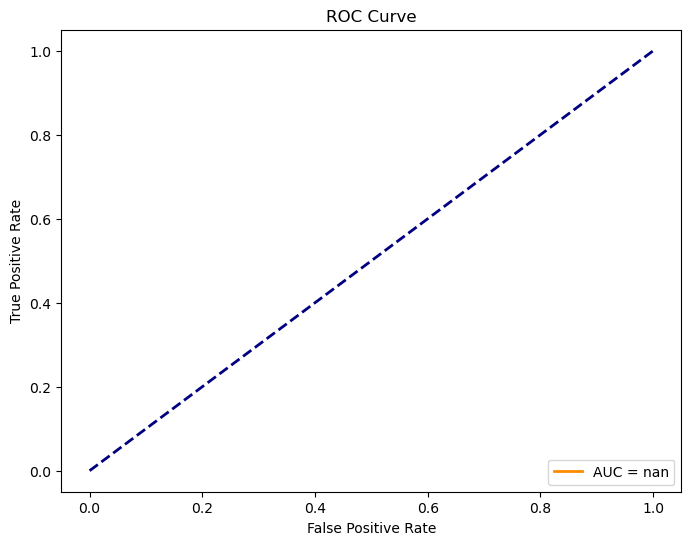

In [32]:
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities for positive class
probs = test_outputs.softmax(dim=1)[:, 1].numpy()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels.numpy(), probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


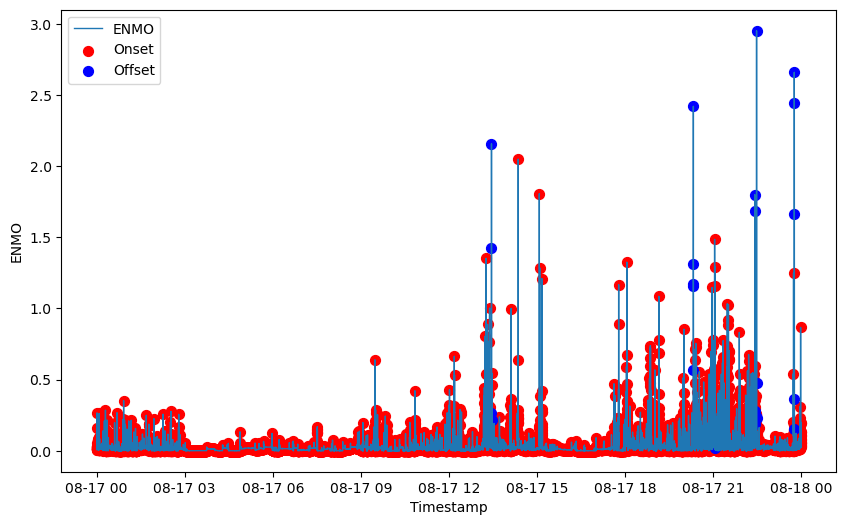

In [16]:
def detect_sleep_events(merged_data, window_size=5, onset_threshold=0.7, offset_threshold=0.3):
 
    enmo_means = merged_data['enmo'].rolling(window=window_size, min_periods=1).mean()
    
    events = []
    for i in range(len(merged_data) - window_size + 1):
        enmo_mean = enmo_means.iloc[i + window_size - 1]
        
        if enmo_mean < onset_threshold:
            events.append({'timestamp': merged_data['timestamp'].iloc[i + window_size // 2], 'event': 'onset'})
        elif enmo_mean > offset_threshold:
            events.append({'timestamp': merged_data['timestamp'].iloc[i + window_size // 2], 'event': 'offset'})
        else:
            events.append({'timestamp': merged_data['timestamp'].iloc[i + window_size // 2], 'event': 'nothing'})

    events_df = pd.concat([pd.DataFrame([event]) for event in events], ignore_index=True)
    return events_df

target_series_id = '038441c925bb'
data_frames = []

for batch in train_parquet.iter_batches():
    batch_df = batch.to_pandas()
    # filter
    filtered_data = batch_df[batch_df['series_id'] == target_series_id]
    data_frames.append(filtered_data)

# combine
combined_data = pd.concat(data_frames, ignore_index=True)
combined_data['timestamp'] = pd.to_datetime(combined_data['timestamp'], utc=True)

# 24 hours
one_day_data = combined_data[combined_data['timestamp'].dt.date == pd.to_datetime('2018-08-17').date()]

# merge the combined data with event data
train_events = pd.read_csv('train_events.csv')
train_events['timestamp'] = pd.to_datetime(train_events['timestamp'], utc=True)
filtered_events = train_events[train_events['series_id'] == target_series_id]
merged_data = pd.merge(one_day_data, filtered_events, on=['timestamp', 'series_id'], how='left')

# detect sleep events
detected_events = detect_sleep_events(merged_data)

plt.figure(figsize=(10, 6))
plt.plot(merged_data['timestamp'], merged_data['enmo'], label='ENMO', linewidth=1)
plt.scatter(detected_events[detected_events['event'] == 'onset']['timestamp'], merged_data.loc[merged_data['timestamp'].isin(detected_events[detected_events['event'] == 'onset']['timestamp']), 'enmo'], c='r', marker='o', label='Onset', s=50)
plt.scatter(detected_events[detected_events['event'] == 'offset']['timestamp'], merged_data.loc[merged_data['timestamp'].isin(detected_events[detected_events['event'] == 'offset']['timestamp']), 'enmo'], c='b', marker='o', label='Offset', s=50)
plt.xlabel('Timestamp')
plt.ylabel('ENMO')
plt.legend()
plt.show()


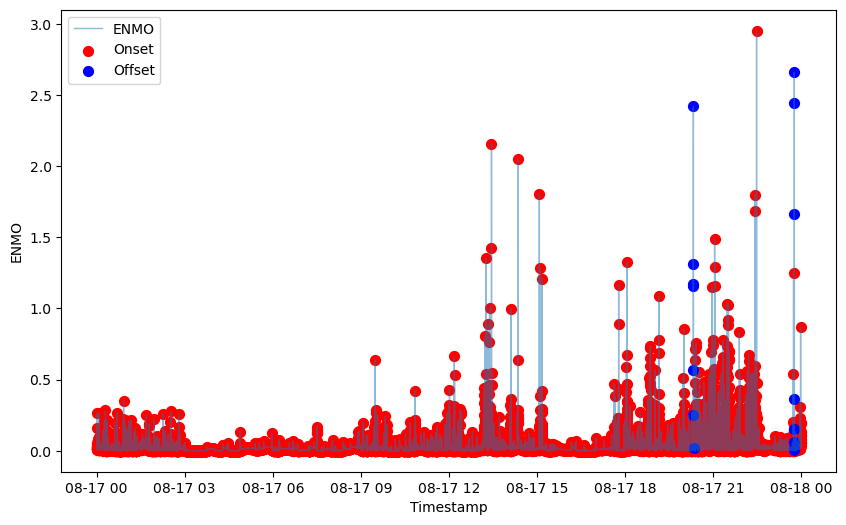

In [17]:
def detect_sleep_events(merged_data, window_size=10, onset_threshold=0.6, offset_threshold=0.4):
    enmo_means = merged_data['enmo'].rolling(window=window_size, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(merged_data['timestamp'], merged_data['enmo'], label='ENMO', linewidth=1, alpha=0.5)
plt.scatter(detected_events[detected_events['event'] == 'onset']['timestamp'], merged_data.loc[merged_data['timestamp'].isin(detected_events[detected_events['event'] == 'onset']['timestamp']), 'enmo'], c='r', marker='o', label='Onset', s=50)
plt.scatter(detected_events[detected_events['event'] == 'offset']['timestamp'], merged_data.loc[merged_data['timestamp'].isin(detected_events[detected_events['event'] == 'offset']['timestamp']), 'enmo'], c='b', marker='o', label='Offset', s=50)
plt.xlabel('Timestamp')
plt.ylabel('ENMO')
plt.legend()
plt.show()


In [8]:
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    test_outputs = model(test_sequences)
    predictions = torch.argmax(test_outputs, dim=1)
    accuracy = torch.sum(predictions == test_labels).item() / len(test_labels)

print(f'Final Accuracy on Test Set: {accuracy:.4f}')

# Print classification report and confusion matrix
print('Classification Report:\n', classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
print('Confusion Matrix:\n', conf_matrix)


Final Accuracy on Test Set: 0.9999
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     77967
           1       0.00      0.00      0.00         4
           2       0.00      0.00      0.00         4

    accuracy                           1.00     77975
   macro avg       0.33      0.33      0.33     77975
weighted avg       1.00      1.00      1.00     77975

Confusion Matrix:
 [[77967     0     0]
 [    4     0     0]
 [    4     0     0]]


C:\Users\aemsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aemsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\aemsh\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


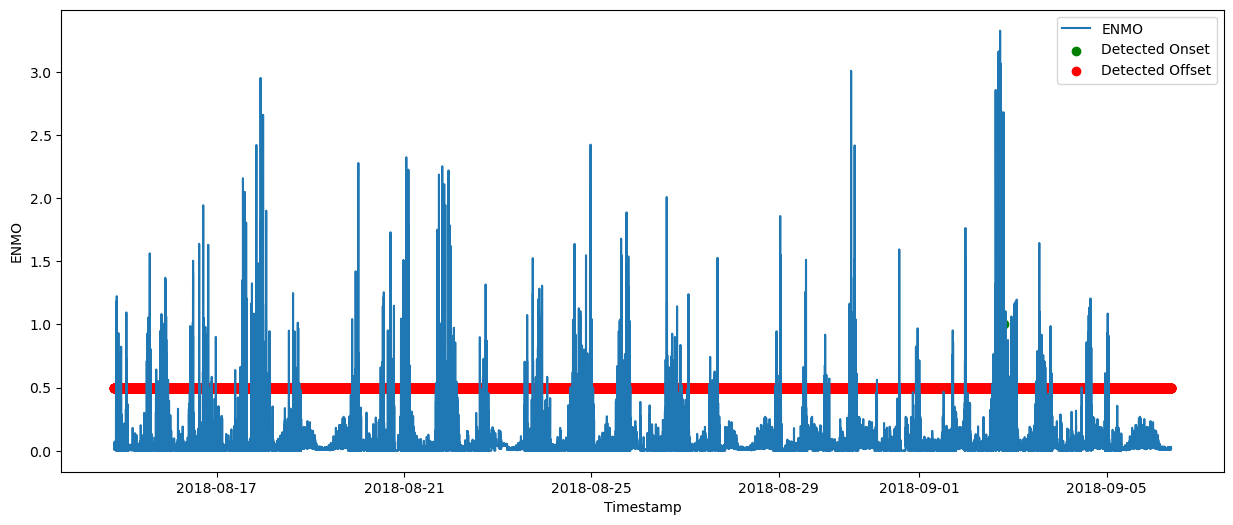

In [17]:
window_size = 10
onset_threshold = 1.0  
offset_threshold = 0.5  

onset_events = []
offset_events = []

for i in range(0, len(merged_data), window_size):
    window = merged_data.iloc[i:i+window_size]

    mean_enmo = window['enmo'].mean()

    # detect onset if mean_enmo exceeds onset_threshold
    if mean_enmo > onset_threshold:
        onset_events.append(window['timestamp'].iloc[0])

    # detect offset if mean_enmo falls below offset_threshold
    if mean_enmo < offset_threshold:
        offset_events.append(window['timestamp'].iloc[0])

# Plot the time series data
plt.figure(figsize=(15, 6))
plt.plot(merged_data['timestamp'], merged_data['enmo'], label='ENMO')

# Plot onset events
plt.scatter(onset_events, [onset_threshold] * len(onset_events), color='green', label='Detected Onset')

# Plot offset events
plt.scatter(offset_events, [offset_threshold] * len(offset_events), color='red', label='Detected Offset')

plt.xlabel('Timestamp')
plt.ylabel('ENMO')
plt.legend()
plt.show()
